This implementation requires Tensorflow 2.1.0, if you set up the environment using the `environment.yml` file, you should be good.

In [1]:
# Run only if you are using Google Colab
%pip install tensorflow==2.1.0
!pip install pyyaml h5py

     |████████████████████████████████| 421.8MB 42kB/s 
     |████████████████████████████████| 3.9MB 25.8MB/s 
     |████████████████████████████████| 450kB 65.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cee93bc946bba3aca9be68f3bb6a320d9d9e0d44b58a8a3911f83dee0d254255
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [0]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [0]:
if tf.__version__ != "2.1.0":
  print("Tensorflow 2.1.0 required...")

Getting Dataset


In [0]:
downloadDataSet = True

In [5]:
# Ensuring dataset is available
if downloadDataSet:
    _URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    path_to_zip = tf.keras.utils.get_file('tiny-imagenet-200.zip', origin=_URL, extract=True)
    PATH = os.path.join(os.path.dirname(path_to_zip), 'tiny-imagenet-200')
else:
    PATH = "./tiny-imagenet-200"

248102912/248100043 [==============================] - 26s 0us/step


In [0]:
# to access the dataset
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [0]:
# to save the model
checkpoint_path = "tinynet.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

Parameters

In [0]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
total_epochs = 50
batch_size = 256
input_shape = (64, 64, 3)
num_classes = 200

Utilities

In [0]:
# callback function to be used during training
def model_callbacks(path):
    # saving the model when validation accuracy increases after an epoch
    checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor = 'val_categorical_accuracy',
                                mode = 'max', save_best_only = True, verbose = 1)
    
    # reducing the learning rate when validation loss saturates or starts increasing 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', factor = 0.1,    
                                  patience = 8, verbose = 1, min_lr = 0.0001)
    
    return [checkpoint, reduce_lr]

In [0]:
# to print 5 of the augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# to plot the results of training - loss, top 1 accuracy and top 5 accuracy
def plot_graph(model, N):
    # loss plot
    plt.figure(0)
    plt.plot(np.arange(0, N), model.history['loss'], label='Training loss')
    plt.plot(np.arange(0, N), model.history['val_loss'], label='Validation loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # top 1 accuracy plot
    plt.figure(1)
    plt.plot(np.arange(0, N), model.history['categorical_accuracy'], label='Top 1 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_categorical_accuracy'], label='Top 1 Validation Accuracy')
    plt.title('Top 1 Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # top 5 accuracy plot
    plt.figure(2)
    plt.plot(np.arange(0, N), model.history['top_k_categorical_accuracy'], label='Top 5 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_top_k_categorical_accuracy'], label='Top 5 Validation Accuracy')
    plt.title('Top 5 Training vs Validation Acuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

Augmentation

In [12]:
# augmenting function with a validation split of 20.00 %
augment = tf.keras.preprocessing.image.ImageDataGenerator(zca_whitening=True, horizontal_flip=True, validation_split = 0.2)

# zca_whitening parameters
augment.mean = 112.69858580973307
augment.std = 70.93752549462194
augment.principal_components = 40

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [13]:
# generating augmented train data
train_data_gen = augment.flow_from_directory(batch_size=batch_size, directory=train_dir,
                                             shuffle=True, target_size=(64, 64),
                                             class_mode='categorical', subset='training')

# generating augmented validation data
val_data_gen = augment.flow_from_directory(batch_size=batch_size, directory = train_dir,
                                              shuffle=True, target_size=(64, 64),
                                              class_mode='categorical', subset = 'validation')

Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


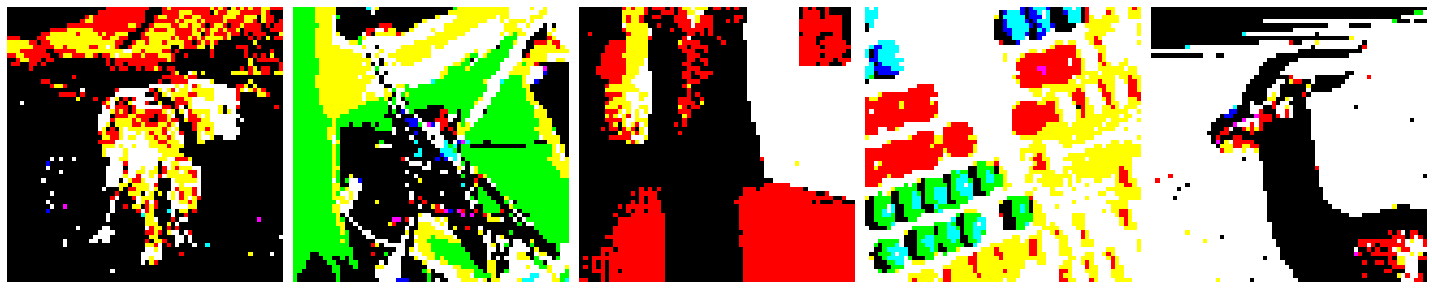

In [14]:
# printing 5 augmented images from training set
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

Model

In [0]:
# tinynet architecture
def build(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # convolution layer 1
    model.add(tf.keras.layers.Convolution2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
    
    # convolution layer 2
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
    
    # convolution layer 3
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # convolution layer 4
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))

    # convolution layer 5
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # convolution layer 6
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # convolution layer 7
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))

    # flattening
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))

    # fully connected layer 1
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu')) 
    model.add(tf.keras.layers.Dropout(0.5))
    
    # fully connected layer 2
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    # output layer
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    return model

In [17]:
# summary of the architecture
build(input_shape, num_classes).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 66, 66, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 128)       5

Training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 79 steps
Epoch 1/50
312/313 [============================>.] - ETA: 0s - loss: 5.4152 - categorical_accuracy: 0.0114 - top_k_categorical_accuracy: 0.0481
Epoch 00001: val_categorical_accuracy improved from -inf to 0.02785, saving model to tinynet.h5
313/313 [==============================] - 73s 233ms/step - loss: 5.4138 - categorical_accuracy: 0.0114 - top_k_categorical_accuracy: 0.0482 - val_loss: 4.9711 - val_categorical_accuracy: 0.0279 - val_top_k_categorical_accuracy: 0.1040
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 4.7166 - categorical_accuracy: 0.0413 - top_k_categorical_accuracy: 0.1519
Epoch 00002: val_categorical_accuracy improved from 0.02785 to 0.08760, saving model to tinynet.h5
313/313 [==============================] - 63s 203ms/step - loss: 4.7157 - categorical_accuracy: 0.0414 - top_k_categorical_accuracy: 0.1521 - val_loss: 4.3516 - val_categorical_accuracy

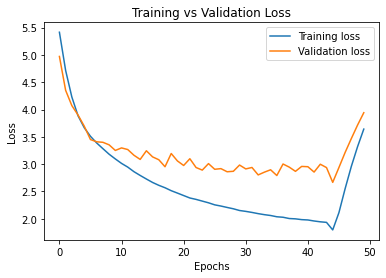

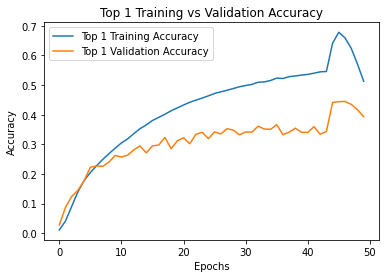

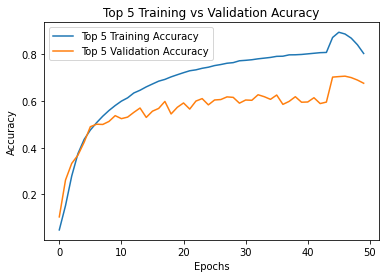

In [18]:
# initializing the model
model_tinynet = build(input_shape, num_classes)
model_tinynet.compile(optimizer=tfa.optimizers.weight_decay_optimizers.SGDW(
                        learning_rate=learning_rate, momentum=momentum, 
                        weight_decay=weight_decay, nesterov=True, name='SGDW'),
                        loss='categorical_crossentropy', 
                        metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

# traing the model
history = model_tinynet.fit(train_data_gen, epochs = total_epochs,
                            validation_data=val_data_gen, verbose=1, 
                            callbacks=model_callbacks(checkpoint_path))

# plotting the results
plot_graph(history, total_epochs)